In [1]:
# imports
import time
from datetime import datetime
import pytz
from collections import deque

# library imports
import requests
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pacswg.timer import TimerClass

# config
my_timezone = os.getenv('PY_TZ', 'America/Toronto')

# small functions
def get_time_with_tz():
    return datetime.now().astimezone(pytz.timezone(my_timezone))

In [21]:
# configs
server_address = 'http://localhost:3000'

# service_name = 'tfserving-resnetv2'
# slo_timeout = 

# service_name = 'bentoml-onnx-resnet50'
# slo_timeout = 

service_name = 'bentoml-iris'
slo_timeout = 500
initial_batch_size = 5
bs_config = {
    'max_bs': 100,
    'min_bs': 1,
    'inc_step': 5,
    'dec_mult': 0.7,
}
average_timeout_ratio_threshold = 0.5

# service_name = 'tfserving-mobilenetv1'
# slo_timeout = 

# SLO
slo_target = slo_timeout * 0.8

# length of measurements used to estimate different batch size response times
upstream_rt_max_len = 1000

# Getting and Setting Stats and Configs

In [3]:
def fetch_raw_server_proxy_stats():
    url = f'{server_address}/proxy-monitor/{service_name}'
    response = requests.get(url)
    response.raise_for_status()
    return response.json()

def get_proxy_stats():
    raw_stats = fetch_raw_server_proxy_stats()
    return {
        'maxBufferSize': raw_stats['maxBufferSize'],
        'averageMaxBufferSize': raw_stats['windowedHistoryValues']['maxBufferSize']['average'],
        'averageActualBatchSize': raw_stats['windowedUpstream']['batchSizes']['average'],
        'maxBufferTimeoutMs': raw_stats['maxBufferTimeoutMs'],
        'currentReplicaCount': raw_stats['currentMonitorStatus']['currentReplicaCount'],
        'currentReadyReplicaCount': raw_stats['currentMonitorStatus']['currentReplicaCount'],
        'currentConcurrency': raw_stats['currentMonitorStatus']['currentConcurrency'],
        'averageConcurrency': raw_stats['windowedHistoryValues']['concurrency']['average'],
        'averageArrivalRate': raw_stats['windowedHistoryValues']['arrival']['rate'],
        'averageDepartureRate': raw_stats['windowedHistoryValues']['departure']['rate'],
        'averageDispatchRate': raw_stats['windowedHistoryValues']['dispatch']['rate'],
        'averageErrorRate': raw_stats['windowedHistoryValues']['error']['rate'],
        'averageTimeoutRatio': raw_stats['windowedHistoryValues']['timeoutRatio']['average'],
        'reponseTimeAverage': raw_stats['responseTimes']['stats']['average'],
        'reponseTimeP50': raw_stats['responseTimes']['stats']['q50'],
        'reponseTimeP95': raw_stats['responseTimes']['stats']['q95'],
        'batchResponseTimeStats': raw_stats['windowedUpstream']['responseTimes'],
    }

def set_proxy_config(update_config):
    url = f'{server_address}/proxy-config/{service_name}'
    response = requests.post(url, json=update_config)
    response.raise_for_status()
    return response.json()


# display(fetch_raw_server_proxy_stats())
# display(get_proxy_stats())
set_proxy_config({
    'maxBufferSize': initial_batch_size,
    'maxBufferTimeoutMs': slo_target,
})

{'serviceName': 'bentoml-iris',
 'upstreamUrl': 'http://bentoml-iris.default.kn.nima-dev.com/predict',
 'maxBufferTimeoutMs': 400,
 'maxBufferSize': 5,
 'isTFServing': False}

In [4]:
proxy_stats = get_proxy_stats()
proxy_stats

{'maxBufferSize': 5,
 'averageMaxBufferSize': 5,
 'averageActualBatchSize': 2.124031007751938,
 'maxBufferTimeoutMs': 400,
 'currentReplicaCount': 2,
 'currentReadyReplicaCount': 2,
 'currentConcurrency': 2,
 'averageConcurrency': 1,
 'averageArrivalRate': 5.35,
 'averageDepartureRate': 5.45,
 'averageDispatchRate': 5.45,
 'averageErrorRate': 0,
 'averageTimeoutRatio': 0.8717948717948718,
 'reponseTimeAverage': 238.67518248175182,
 'reponseTimeP50': 224.5,
 'reponseTimeP95': 378,
 'batchResponseTimeStats': {'1': {'values': [18,
    19,
    19,
    20,
    20,
    20,
    21,
    21,
    21,
    21,
    21,
    21,
    22,
    22,
    22,
    22,
    22,
    22,
    23,
    23,
    23,
    23,
    23,
    23,
    23,
    24,
    24,
    24,
    24,
    24,
    24,
    24,
    24,
    24,
    24,
    25,
    25,
    25,
    25,
    26,
    26,
    26,
    26,
    26,
    27,
    27,
    27,
    27,
    27,
    27,
    27,
    28,
    30,
    31,
    31,
    115,
    5628],
   'stats': {'

In [5]:
def update_batch_rt_values(batch_rt_values, proxy_stats):
    for batch_size_str in proxy_stats['batchResponseTimeStats']:
        batch_size = int(batch_size_str)
        if not(batch_size in batch_rt_values):
            batch_rt_values[batch_size] = deque(maxlen=upstream_rt_max_len)
        # concatenate arrays
        batch_rt_values[batch_size].extend(proxy_stats['batchResponseTimeStats'][batch_size_str]['values'])

    return batch_rt_values

batch_rt_values = {}
batch_rt_values = update_batch_rt_values(batch_rt_values, proxy_stats)

In [6]:
# run a loop to monitor response times to test the functionality
timer = TimerClass()

batch_rt_values = {}
for _ in tqdm(range(1*6)):
    timer.tic()
    proxy_stats = get_proxy_stats()
    batch_rt_values = update_batch_rt_values(batch_rt_values, proxy_stats)
    while timer.toc() < 10:
        time.sleep(1)


  0%|          | 0/6 [00:00<?, ?it/s]

,batch_size,average_response_time,median_response_time,p95_response_time
0,1,54.326633,25.0,34.0
1,2,27.984293,24.0,36.0
2,3,24.083333,23.0,31.0
3,4,26.615385,25.0,33.0
4,5,25.000000,23.0,55.0


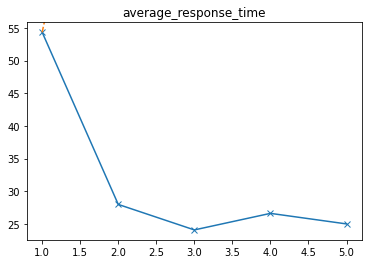

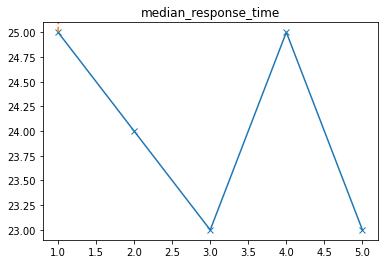

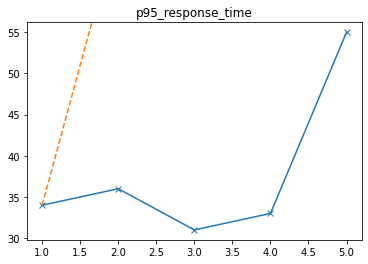

In [8]:
def analyze_batch_results(batch_rt_values):
    batch_size_results = []
    for bs, vals in batch_rt_values.items():
        # print(bs, len(vals), np.mean(vals))
        batch_size_results.append({
            'batch_size': bs,
            'average_response_time': np.mean(vals),
            'median_response_time': np.median(vals),
            'p95_response_time': np.percentile(vals,95),
        })

    df_batch_size = pd.DataFrame(data=batch_size_results)
    df_batch_size = df_batch_size.sort_values(by='batch_size')
    return df_batch_size

def plot_key_vs_batch_size(key, df_batch_size):
    plt.figure()
    plt.plot(df_batch_size['batch_size'], df_batch_size[key], marker='x')
    prev_ylim = plt.gca().get_ylim()
    # relative average response time by batch size (linear scale)
    relative_scaled_response_time = df_batch_size['batch_size']/df_batch_size['batch_size'].iloc[0]*df_batch_size[key].iloc[0]
    # plot the linear baseline
    plt.plot(df_batch_size['batch_size'], relative_scaled_response_time, ls='--')
    plt.ylim(prev_ylim)
    plt.title(key)

df_batch_size = analyze_batch_results(batch_rt_values)
display(df_batch_size)
plot_key_vs_batch_size('average_response_time', df_batch_size)
plot_key_vs_batch_size('median_response_time', df_batch_size)
plot_key_vs_batch_size('p95_response_time', df_batch_size)

# Create Control Algorithms

In [28]:
def calculate_new_bs(curr_bs, inc=True, config=None):
    if config is None:
        config = {
            'max_bs': 100,
            'min_bs': 20,
            'inc_step': 1,
            'dec_mult': 0.7,
        }

    if inc:
        new_bs = curr_bs + config['inc_step']
        # at least one step is made
        new_bs = max(new_bs, curr_bs+1)
    else:
        new_bs = curr_bs * config['dec_mult']
        new_bs = int(new_bs)
        # at least one step is made
        new_bs = min(new_bs, curr_bs-1)

    new_bs = min(new_bs, config['max_bs'])
    new_bs = max(new_bs, config['min_bs'])

    return new_bs

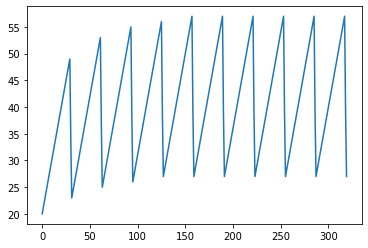

In [29]:
all_bs = []
curr_bs = 10
for _ in range(10):
    for _ in range(30):
        curr_bs = calculate_new_bs(curr_bs, True)
        all_bs.append(curr_bs)
    for _ in range(2):
        curr_bs = calculate_new_bs(curr_bs, False)
        all_bs.append(curr_bs)

plt.plot(all_bs)

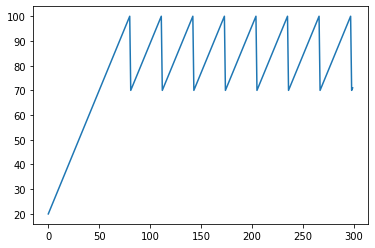

In [30]:
all_bs = []
curr_bs = 10
target = 90
for _ in range(300):
    if curr_bs > target * 1.1:
        curr_bs = calculate_new_bs(curr_bs, False)
    else:
        curr_bs = calculate_new_bs(curr_bs, True)

    all_bs.append(curr_bs)

plt.plot(all_bs)

# Test Changing The Configuration

In [35]:
# initialize
proxy_stats = get_proxy_stats()
curr_bs = proxy_stats['maxBufferSize']

In [45]:
acc_proxy_stats = []

for _ in tqdm(range(30*2)):
    proxy_stats = get_proxy_stats()
    acc_proxy_stats.append(proxy_stats)

    # the condition for increasing or decreasing batch size
    shouldIncrease = proxy_stats['reponseTimeP95'] < slo_target
    shouldIncrease = shouldIncrease and (proxy_stats['averageTimeoutRatio'] < average_timeout_ratio_threshold)

    new_bs = calculate_new_bs(curr_bs, shouldIncrease, bs_config)

    set_proxy_config({
        'maxBufferSize': new_bs,
        'maxBufferTimeoutMs': slo_target,
    })

    print(curr_bs, new_bs)
    print(proxy_stats['averageTimeoutRatio'])
    print('------')

    # update current batch size
    curr_bs = new_bs
    time.sleep(30)

  0%|          | 0/6 [00:00<?, ?it/s]

5 3
0.8
------
3 2
0.5581395348837209
------
2 7
0.2727272727272727
------
7 12
0.4375
------
12 8
0.9705882352941176
------
8 5
1
------


In [47]:
pd.DataFrame(data=acc_proxy_stats)

,maxBufferSize,averageMaxBufferSize,averageActualBatchSize,maxBufferTimeoutMs,currentReplicaCount,currentReadyReplicaCount,currentConcurrency,averageConcurrency,averageArrivalRate,averageDepartureRate,averageDispatchRate,averageErrorRate,averageTimeoutRatio,reponseTimeAverage,reponseTimeP50,reponseTimeP95,batchResponseTimeStats
0,5,5.0,2.649123,400,1,1,0,2.2,6.00,5.90,5.9,0,0.800000,247.655629,270.5,383,"{'1': {'values': [21, 22, 23, 23, 23, 23, 24, ..."
1,3,4.0,2.632479,400,1,1,2,1.6,5.95,6.10,6.1,0,0.558140,234.357143,233.0,383,"{'1': {'values': [21, 22, 23, 23, 23, 24, 25, ..."
2,2,2.5,2.480916,400,1,1,1,0.8,6.00,6.10,6.1,0,0.272727,209.901538,199.0,383,"{'1': {'values': [21, 22, 23, 23, 23, 24, 25, ..."
3,7,4.5,2.500000,400,1,1,1,1.4,5.25,5.00,5.0,0,0.437500,207.784375,198.5,384,"{'1': {'values': [21, 22, 23, 23, 23, 23, 24, ..."
4,12,9.5,2.585938,400,1,1,1,1.8,4.60,4.55,4.6,0,0.970588,213.126888,208.0,384,"{'1': {'values': [21, 22, 23, 23, 23, 23, 24, ..."
5,8,10.0,2.582677,400,1,1,0,1.3,5.15,5.30,5.3,0,1.000000,221.329268,228.5,384,"{'1': {'values': [22, 23, 23, 23, 24, 25, 28, ..."
